# Notebook 01: Data Exploration and Preparation
## Benchmarking SAM & MedSAM Robustness under Noisy Abdominal CT Conditions

**Author:** Hoang Le Chau   
**Date:** January 2026  
**Datasets:** Medical Segmentation Decathlon - Task 03 (Liver) & Task 09 (Spleen)

---

### Objective
This notebook explores and prepares the Medical Segmentation Decathlon (MSD) datasets for evaluating SAM model robustness under noisy conditions. We will:
1. Load and inspect the datasets
2. Analyze data distributions and characteristics
3. Prepare data structures for downstream processing
4. Extract representative slices for benchmarking

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import json
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-paper')
%matplotlib inline

print("Libraries imported successfully")

Libraries imported successfully


### 1. Mount Google Drive and Set Paths

In [2]:
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = Path('/content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy/')
DATASET_PATH = BASE_PATH / 'datasets'
LIVER_PATH = DATASET_PATH / 'Task03_Liver'
SPLEEN_PATH = DATASET_PATH / 'Task09_Spleen'

OUTPUT_PATH = BASE_PATH / 'SAM_Robustness_Study'
OUTPUT_PATH.mkdir(exist_ok=True, parents=True)

PROCESSED_DATA_PATH = OUTPUT_PATH / 'processed_data'
PROCESSED_DATA_PATH.mkdir(exist_ok=True)

print(f"Base path: {BASE_PATH}")
print(f"Liver dataset: {LIVER_PATH}")
print(f"Spleen dataset: {SPLEEN_PATH}")
print(f"Output path: {OUTPUT_PATH}")

Mounted at /content/drive
Base path: /content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy
Liver dataset: /content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy/datasets/Task03_Liver
Spleen dataset: /content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy/datasets/Task09_Spleen
Output path: /content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy/SAM_Robustness_Study


### 2. Dataset Information Loading

In [3]:
def load_dataset_info(dataset_path):
    """
    Load dataset.json file containing metadata.

    Args:
        dataset_path: Path to dataset folder

    Returns:
        Dictionary containing dataset metadata
    """
    json_path = dataset_path / 'dataset.json'
    if json_path.exists():
        with open(json_path, 'r') as f:
            return json.load(f)
    else:
        print(f"Warning: dataset.json not found at {json_path}")
        return None

liver_info = load_dataset_info(LIVER_PATH)
spleen_info = load_dataset_info(SPLEEN_PATH)

if liver_info:
    print("\n=== Liver Dataset Info ===")
    print(f"Name: {liver_info.get('name', 'N/A')}")
    print(f"Description: {liver_info.get('description', 'N/A')}")
    print(f"Modality: {liver_info.get('modality', 'N/A')}")
    print(f"Number of training samples: {liver_info.get('numTraining', 'N/A')}")

if spleen_info:
    print("\n=== Spleen Dataset Info ===")
    print(f"Name: {spleen_info.get('name', 'N/A')}")
    print(f"Description: {spleen_info.get('description', 'N/A')}")
    print(f"Modality: {spleen_info.get('modality', 'N/A')}")
    print(f"Number of training samples: {spleen_info.get('numTraining', 'N/A')}")


=== Liver Dataset Info ===
Name: Liver
Description: Liver, and cancer segmentation
Modality: {'0': 'CT'}
Number of training samples: 131

=== Spleen Dataset Info ===
Name: Spleen
Description: Spleen Segmentation
Modality: {'0': 'CT'}
Number of training samples: 41


### 3. Data Loading Functions

In [4]:
def load_nifti_volume(file_path):
    """
    Load NIfTI volume and return image data and affine matrix.

    Args:
        file_path: Path to .nii.gz file

    Returns:
        tuple: (image_data, affine_matrix, header)
    """
    nii = nib.load(str(file_path))
    return nii.get_fdata(), nii.affine, nii.header

def get_dataset_files(dataset_path):
    """
    Get all image and label files from dataset.

    Args:
        dataset_path: Path to dataset folder

    Returns:
        tuple: (image_files, label_files)
    """
    images_path = dataset_path / 'imagesTr'
    labels_path = dataset_path / 'labelsTr'

    image_files = sorted(list(images_path.glob('*.nii.gz')))
    label_files = sorted(list(labels_path.glob('*.nii.gz')))

    return image_files, label_files

liver_images, liver_labels = get_dataset_files(LIVER_PATH)
spleen_images, spleen_labels = get_dataset_files(SPLEEN_PATH)

print(f"\nLiver - Images: {len(liver_images)}, Labels: {len(liver_labels)}")
print(f"Spleen - Images: {len(spleen_images)}, Labels: {len(spleen_labels)}")


Liver - Images: 131, Labels: 131
Spleen - Images: 41, Labels: 41


### 4. Analyze Volume Characteristics

In [5]:
def analyze_volumes(image_files, label_files, dataset_name):
    """
    Analyze 3D volume characteristics.

    Args:
        image_files: List of image file paths
        label_files: List of label file paths
        dataset_name: Name of dataset for display

    Returns:
        DataFrame with volume statistics
    """
    stats = []

    print(f"\nAnalyzing {dataset_name} volumes...")
    for img_path, lbl_path in tqdm(zip(image_files[:10], label_files[:10]),
                                     total=min(10, len(image_files))):
        img_data, _, _ = load_nifti_volume(img_path)
        lbl_data, _, _ = load_nifti_volume(lbl_path)

        stats.append({
            'filename': img_path.name,
            'shape': img_data.shape,
            'num_slices': img_data.shape[2],
            'img_min': img_data.min(),
            'img_max': img_data.max(),
            'img_mean': img_data.mean(),
            'img_std': img_data.std(),
            'label_classes': len(np.unique(lbl_data)),
            'foreground_ratio': (lbl_data > 0).sum() / lbl_data.size
        })

    return pd.DataFrame(stats)

liver_stats = analyze_volumes(liver_images, liver_labels, "Liver")
spleen_stats = analyze_volumes(spleen_images, spleen_labels, "Spleen")

print("\n=== Liver Dataset Statistics ===")
print(liver_stats[['filename', 'num_slices', 'img_mean', 'img_std', 'foreground_ratio']].head())

print("\n=== Spleen Dataset Statistics ===")
print(spleen_stats[['filename', 'num_slices', 'img_mean', 'img_std', 'foreground_ratio']].head())


Analyzing Liver volumes...


100%|██████████| 10/10 [01:45<00:00, 10.54s/it]



Analyzing Spleen volumes...


100%|██████████| 10/10 [00:36<00:00,  3.67s/it]


=== Liver Dataset Statistics ===
           filename  num_slices    img_mean     img_std  foreground_ratio
0    liver_0.nii.gz          75 -523.420332  501.559641          0.028108
1    liver_1.nii.gz         123 -527.405821  494.890505          0.020189
2   liver_10.nii.gz         501 -493.621486  503.642889          0.021942
3  liver_100.nii.gz         685 -432.611981  492.980762          0.036603
4  liver_101.nii.gz         683 -399.069654  496.897859          0.038315

=== Spleen Dataset Statistics ===
           filename  num_slices    img_mean     img_std  foreground_ratio
0  spleen_10.nii.gz          55 -450.261741  481.565093          0.003681
1  spleen_12.nii.gz         168 -568.891142  497.496176          0.012209
2  spleen_13.nii.gz          77 -464.471557  496.942699          0.010102
3  spleen_14.nii.gz          54 -481.528353  493.475779          0.008771
4  spleen_16.nii.gz          61 -471.438581  496.645377          0.002504


### 5. Extract Representative 2D Slices

For SAM evaluation, we need high-quality 2D slices with visible anatomical structures.

In [6]:
def extract_slices_with_labels(image_files, label_files, num_volumes=10,
                               slices_per_volume=5, min_foreground_ratio=0.01):
    """
    Extract 2D slices from 3D volumes, selecting slices with sufficient anatomical content.

    Args:
        image_files: List of image file paths
        label_files: List of label file paths
        num_volumes: Number of volumes to process
        slices_per_volume: Number of slices to extract per volume
        min_foreground_ratio: Minimum ratio of foreground pixels

    Returns:
        Dictionary containing extracted slices and metadata
    """
    extracted_data = {
        'images': [],
        'labels': [],
        'metadata': []
    }

    for vol_idx in tqdm(range(min(num_volumes, len(image_files)))):
        img_data, _, _ = load_nifti_volume(image_files[vol_idx])
        lbl_data, _, _ = load_nifti_volume(label_files[vol_idx])

        num_slices = img_data.shape[2]

        foreground_ratios = []
        for slice_idx in range(num_slices):
            ratio = (lbl_data[:, :, slice_idx] > 0).sum() / lbl_data[:, :, slice_idx].size
            foreground_ratios.append(ratio)

        foreground_ratios = np.array(foreground_ratios)
        valid_slices = np.where(foreground_ratios >= min_foreground_ratio)[0]

        if len(valid_slices) > 0:
            selected_indices = np.linspace(0, len(valid_slices)-1,
                                          min(slices_per_volume, len(valid_slices)),
                                          dtype=int)
            selected_slices = valid_slices[selected_indices]

            for slice_idx in selected_slices:
                img_slice = img_data[:, :, slice_idx]
                lbl_slice = lbl_data[:, :, slice_idx]

                extracted_data['images'].append(img_slice)
                extracted_data['labels'].append(lbl_slice)
                extracted_data['metadata'].append({
                    'volume_idx': vol_idx,
                    'slice_idx': slice_idx,
                    'volume_name': image_files[vol_idx].name,
                    'foreground_ratio': foreground_ratios[slice_idx],
                    'shape': img_slice.shape
                })

    extracted_data['images'] = np.array(extracted_data['images'])
    extracted_data['labels'] = np.array(extracted_data['labels'])

    return extracted_data

print("\nExtracting Liver slices...")
liver_slices = extract_slices_with_labels(liver_images, liver_labels,
                                          num_volumes=10, slices_per_volume=5)

print("\nExtracting Spleen slices...")
spleen_slices = extract_slices_with_labels(spleen_images, spleen_labels,
                                           num_volumes=10, slices_per_volume=5)

print(f"\nLiver: Extracted {len(liver_slices['images'])} slices")
print(f"Spleen: Extracted {len(spleen_slices['images'])} slices")


Extracting Liver slices...


100%|██████████| 10/10 [00:37<00:00,  3.73s/it]



Extracting Spleen slices...


100%|██████████| 10/10 [00:06<00:00,  1.64it/s]



Liver: Extracted 50 slices
Spleen: Extracted 50 slices


### 6. Visualize Sample Slices

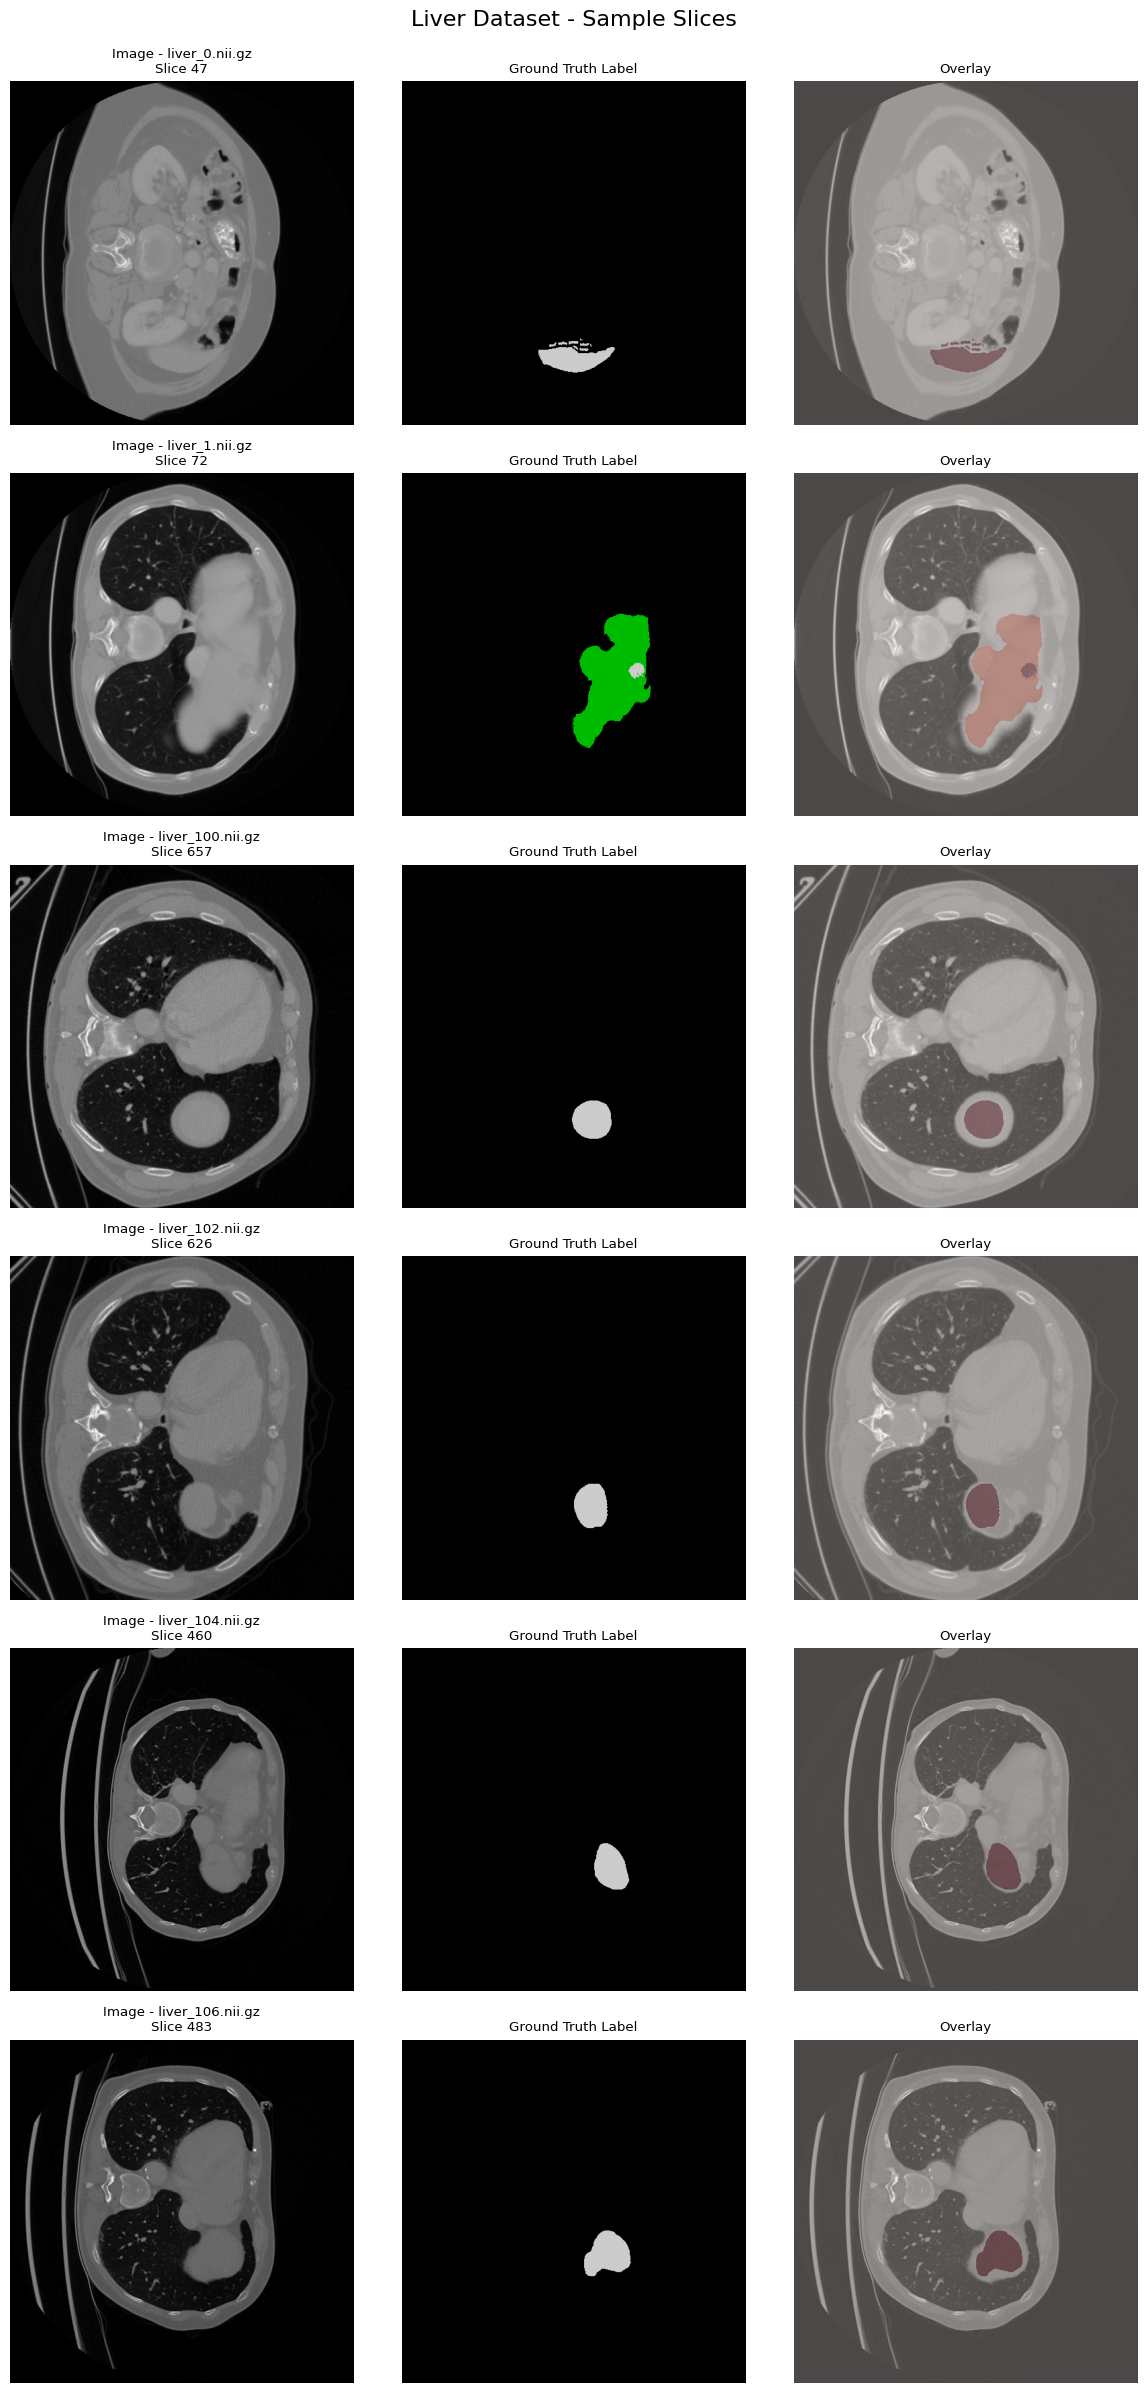

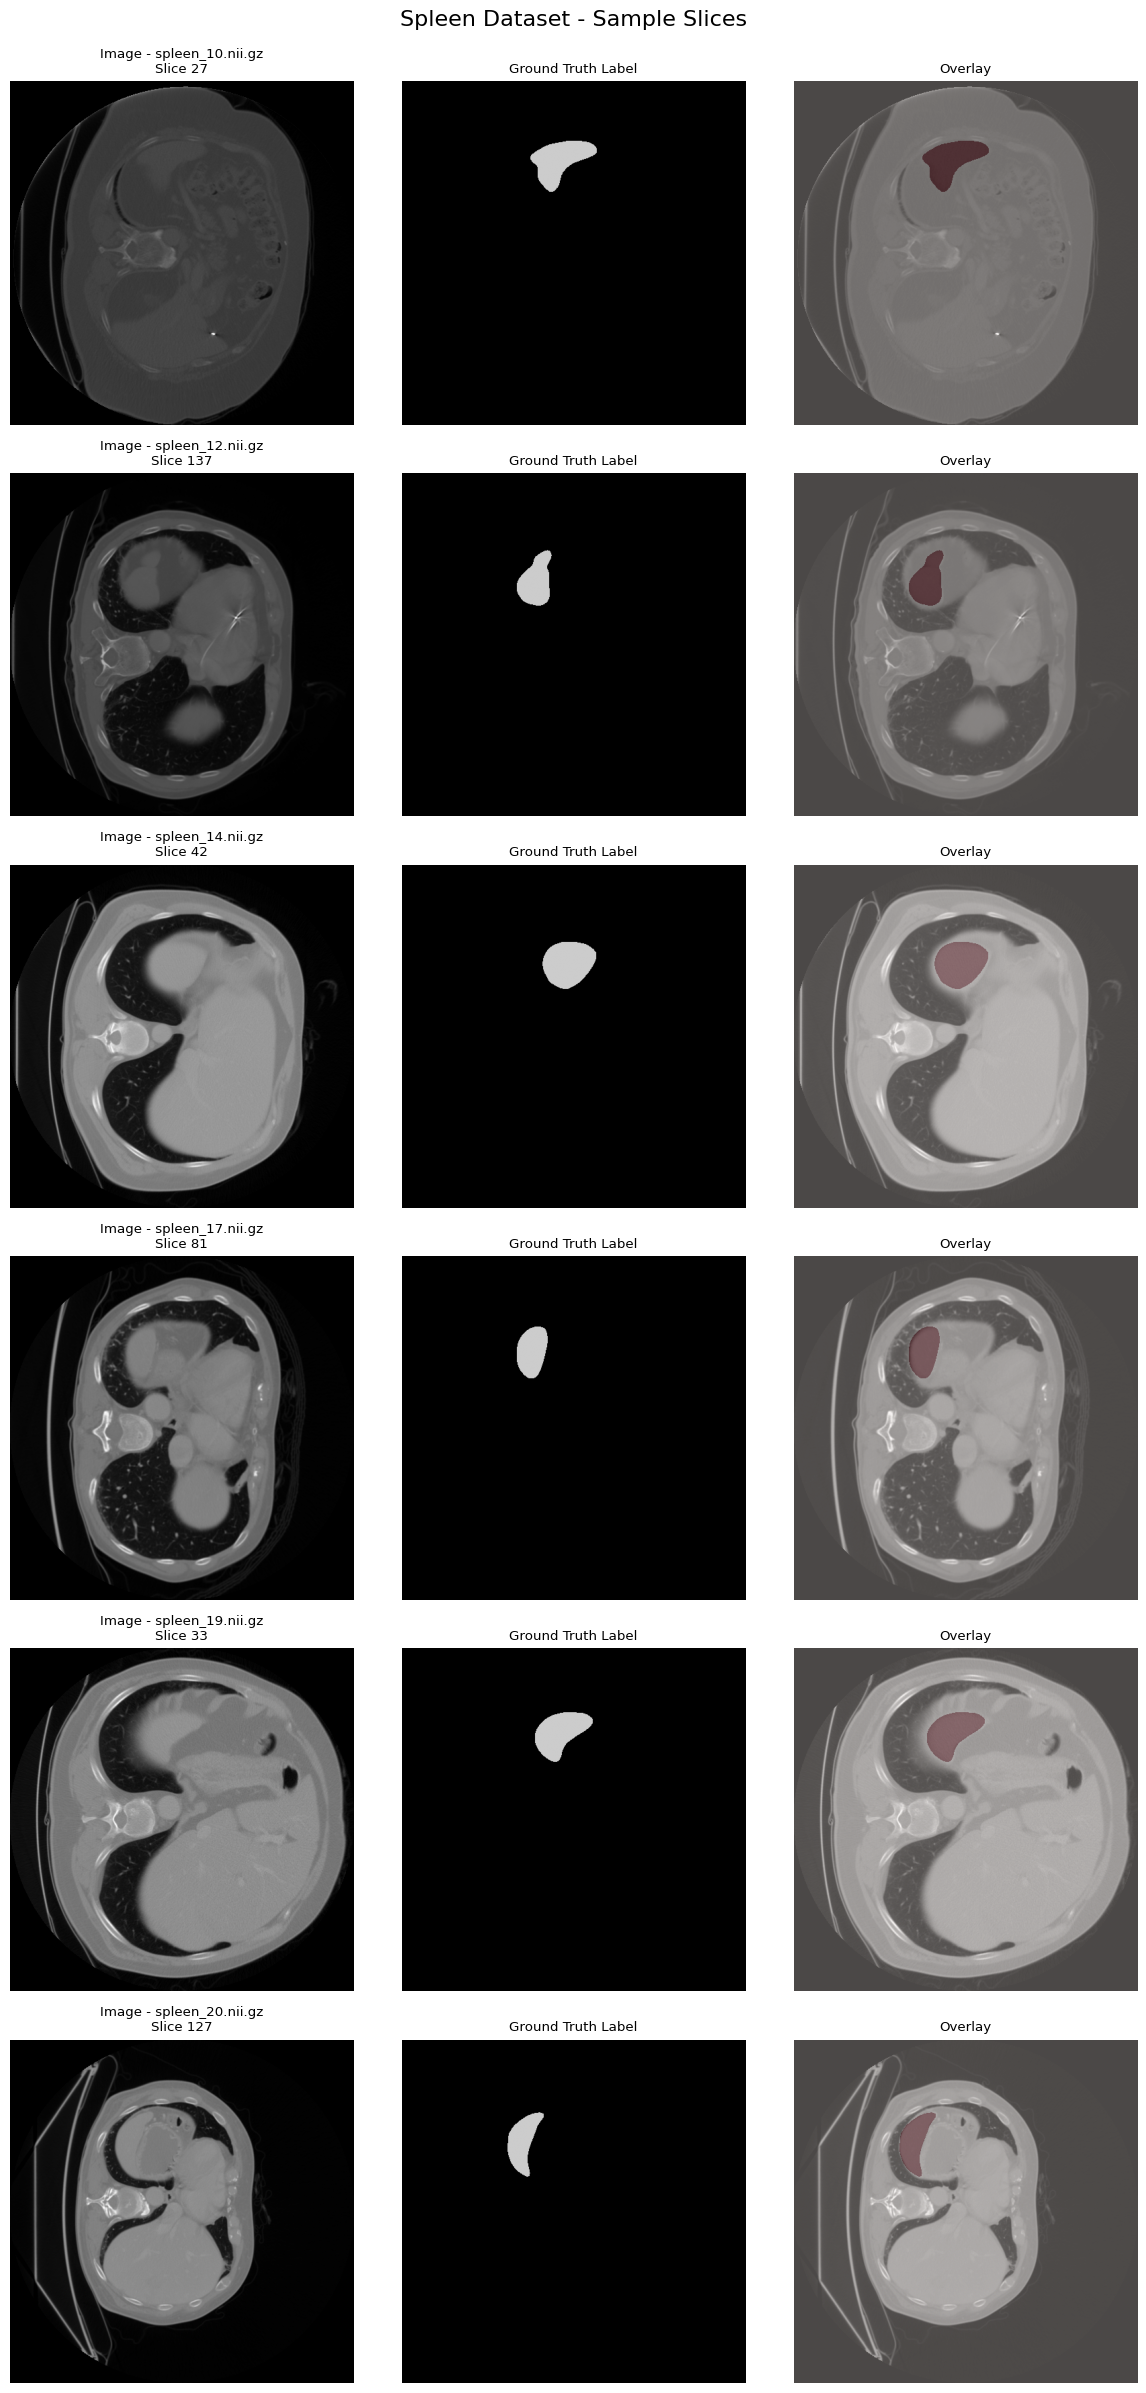

In [7]:
def visualize_samples(data_dict, dataset_name, num_samples=6):
    """
    Visualize sample slices with their corresponding labels.

    Args:
        data_dict: Dictionary containing images and labels
        dataset_name: Name for display
        num_samples: Number of samples to visualize
    """
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))

    indices = np.linspace(0, len(data_dict['images'])-1, num_samples, dtype=int)

    for idx, sample_idx in enumerate(indices):
        img = data_dict['images'][sample_idx]
        lbl = data_dict['labels'][sample_idx]
        metadata = data_dict['metadata'][sample_idx]

        axes[idx, 0].imshow(img, cmap='gray')
        axes[idx, 0].set_title(f"Image - {metadata['volume_name']}\nSlice {metadata['slice_idx']}")
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(lbl, cmap='nipy_spectral')
        axes[idx, 1].set_title(f"Ground Truth Label")
        axes[idx, 1].axis('off')

        axes[idx, 2].imshow(img, cmap='gray')
        axes[idx, 2].imshow(lbl, cmap='Reds', alpha=0.3)
        axes[idx, 2].set_title(f"Overlay")
        axes[idx, 2].axis('off')

    plt.suptitle(f"{dataset_name} Dataset - Sample Slices", fontsize=16, y=0.995)
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / f'{dataset_name.lower()}_samples.png', dpi=150, bbox_inches='tight')
    plt.show()

visualize_samples(liver_slices, "Liver", num_samples=6)
visualize_samples(spleen_slices, "Spleen", num_samples=6)

### 7. Intensity Distribution Analysis

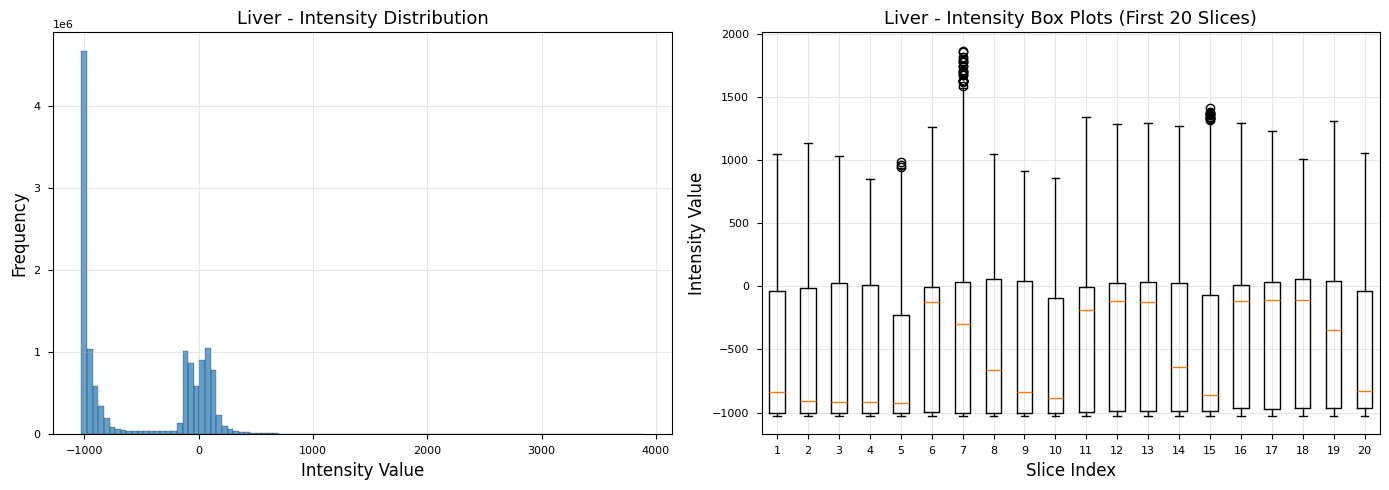


Liver Intensity Statistics:
  Min: -1024.00
  Max: 3892.00
  Mean: -514.08
  Std: 501.26


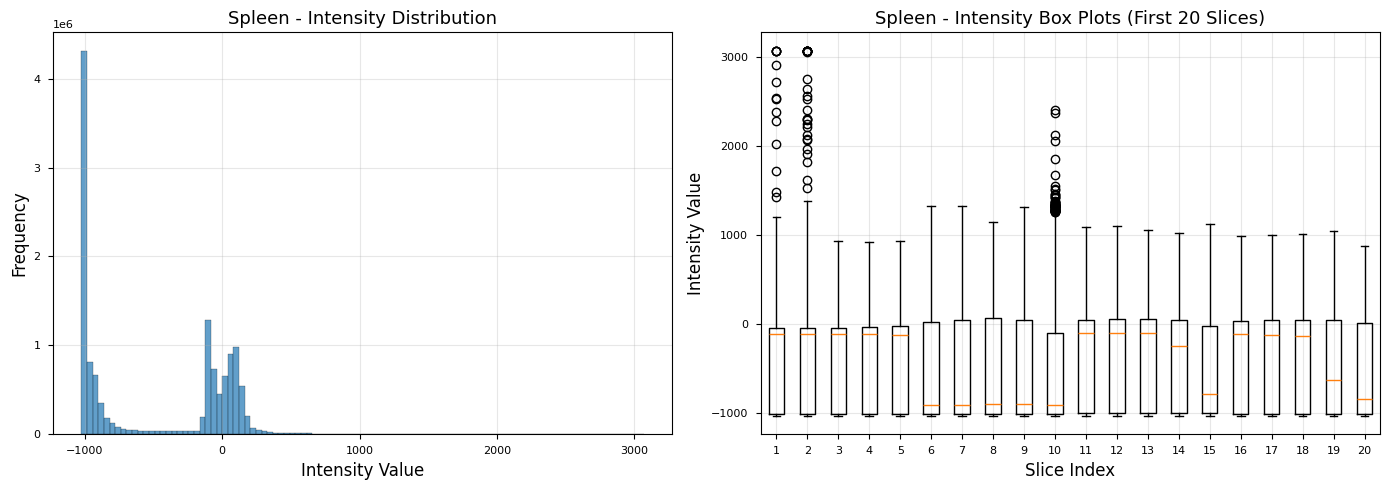


Spleen Intensity Statistics:
  Min: -1024.00
  Max: 3072.00
  Mean: -491.90
  Std: 502.17


In [8]:
def plot_intensity_distributions(data_dict, dataset_name):
    """
    Plot intensity distributions for the extracted slices.

    Args:
        data_dict: Dictionary containing images
        dataset_name: Name for display
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    all_intensities = data_dict['images'].flatten()

    axes[0].hist(all_intensities, bins=100, alpha=0.7, edgecolor='black')
    axes[0].set_xlabel('Intensity Value', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title(f'{dataset_name} - Intensity Distribution', fontsize=13)
    axes[0].grid(alpha=0.3)

    axes[1].boxplot([img.flatten() for img in data_dict['images'][:20]])
    axes[1].set_xlabel('Slice Index', fontsize=12)
    axes[1].set_ylabel('Intensity Value', fontsize=12)
    axes[1].set_title(f'{dataset_name} - Intensity Box Plots (First 20 Slices)', fontsize=13)
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(OUTPUT_PATH / f'{dataset_name.lower()}_intensity_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\n{dataset_name} Intensity Statistics:")
    print(f"  Min: {all_intensities.min():.2f}")
    print(f"  Max: {all_intensities.max():.2f}")
    print(f"  Mean: {all_intensities.mean():.2f}")
    print(f"  Std: {all_intensities.std():.2f}")

plot_intensity_distributions(liver_slices, "Liver")
plot_intensity_distributions(spleen_slices, "Spleen")

### 8. Save Processed Data

In [9]:
def save_processed_data(data_dict, dataset_name, output_path):
    """
    Save extracted slices and metadata to disk.

    Args:
        data_dict: Dictionary containing images, labels, and metadata
        dataset_name: Name of dataset
        output_path: Path to save data
    """
    dataset_output_path = output_path / dataset_name.lower()
    dataset_output_path.mkdir(exist_ok=True)

    np.save(dataset_output_path / 'images.npy', data_dict['images'])
    np.save(dataset_output_path / 'labels.npy', data_dict['labels'])

    metadata_df = pd.DataFrame(data_dict['metadata'])
    metadata_df.to_csv(dataset_output_path / 'metadata.csv', index=False)

    print(f"\nSaved {dataset_name} data to {dataset_output_path}")
    print(f"  Images shape: {data_dict['images'].shape}")
    print(f"  Labels shape: {data_dict['labels'].shape}")
    print(f"  Metadata entries: {len(data_dict['metadata'])}")

save_processed_data(liver_slices, "Liver", PROCESSED_DATA_PATH)
save_processed_data(spleen_slices, "Spleen", PROCESSED_DATA_PATH)


Saved Liver data to /content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy/SAM_Robustness_Study/processed_data/liver
  Images shape: (50, 512, 512)
  Labels shape: (50, 512, 512)
  Metadata entries: 50

Saved Spleen data to /content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy/SAM_Robustness_Study/processed_data/spleen
  Images shape: (50, 512, 512)
  Labels shape: (50, 512, 512)
  Metadata entries: 50


### 9. Summary Statistics

In [10]:
summary = {
    'Liver': {
        'Total Slices': len(liver_slices['images']),
        'Image Shape': liver_slices['images'][0].shape,
        'Mean Foreground Ratio': np.mean([m['foreground_ratio'] for m in liver_slices['metadata']]),
        'Intensity Range': f"{liver_slices['images'].min():.2f} - {liver_slices['images'].max():.2f}"
    },
    'Spleen': {
        'Total Slices': len(spleen_slices['images']),
        'Image Shape': spleen_slices['images'][0].shape,
        'Mean Foreground Ratio': np.mean([m['foreground_ratio'] for m in spleen_slices['metadata']]),
        'Intensity Range': f"{spleen_slices['images'].min():.2f} - {spleen_slices['images'].max():.2f}"
    }
}

summary_df = pd.DataFrame(summary).T
print("\n" + "="*60)
print("DATASET PREPARATION SUMMARY")
print("="*60)
print(summary_df)
print("="*60)

summary_df.to_csv(OUTPUT_PATH / 'dataset_summary.csv')
print(f"\nSummary saved to {OUTPUT_PATH / 'dataset_summary.csv'}")


DATASET PREPARATION SUMMARY
       Total Slices Image Shape Mean Foreground Ratio     Intensity Range
Liver            50  (512, 512)              0.064485  -1024.00 - 3892.00
Spleen           50  (512, 512)              0.018837  -1024.00 - 3072.00

Summary saved to /content/drive/MyDrive/Colab Notebooks/AIMA/sam_noisy/SAM_Robustness_Study/dataset_summary.csv
